### Q-learning / Reinforcement learning, example 4, FrozenLake, dead end grid

Imports + make the environment

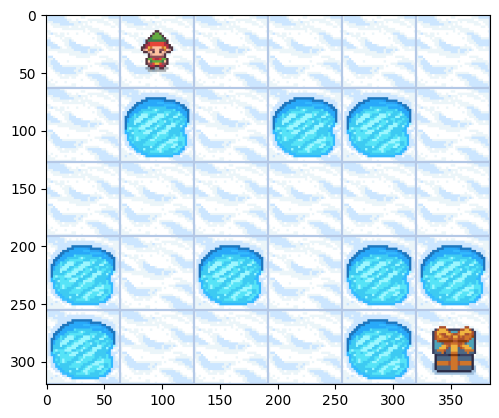

In [1]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

# documentation for this environment:
# https://gymnasium.farama.org/environments/toy_text/frozen_lake/

# define a custom map, symbol meaning:
# S => start (only one start allowed) 
# G => goal (it seems there can be multiple goals, at least one needed)
# F => normal ice tile 
# H => hole
custom_map = ["FSFFFF",
              "FHFHHF",
              "FFFFFF",
              "HFHFHH",
              "HFFFHG"]

# EXTRA TASK IDEA: try larger environments with more than 1 goal
# probably better to use completely randomized grids with multiple goals
# this also probably makes more sense when slippery is ON

# create the FrozenLake -environment
# NOTE! use the desc-parameter to apply a custom map template
env = gym.make("FrozenLake-v1", is_slippery=False, render_mode="rgb_array", desc=custom_map)

# we need to know the exact size of the environment in later visualizations/metrics
grid_height, grid_width = env.unwrapped.desc.shape

# reset environment and see the start screen
env.reset()
plt.imshow(env.render())

### Define the environment spaces and the Q-TABLE!

In [2]:
# let's inspect the environment
print("Observation space:")
print(env.observation_space)

print("\nAction space:")
print(env.action_space)

# in other words, observation space => 4 x 4 grid => 16 cells
# action space => 4 different movements possible => up, right, down, left

Observation space:
Discrete(30)

Action space:
Discrete(4)


In [3]:
# we use the above information to generate an EMPTY Q-table (initial situation)

# basically Q-table will hold the Quality-values (Q-values) for each possible action
# for each possible cell in the grid (basically we map out all possibilities in this environment)
Q_table = np.zeros([env.observation_space.n, env.action_space.n])
Q_table.shape

(30, 4)

### Q-learning formula

**Q(s, a) = Q(s,a) + alpha * (r + y * max(Q(s', a')) - Q(s, a))**

In [4]:
# let's code the above equation into Q-learning update function
def calculate_value(Q, state, action, reward, next_state, alpha, gamma):
    Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])
    return Q

### Helper function to visualize Q-values

In [5]:
def summarize_best_values(q_table, grid_width, grid_height):
    # get a list of highest values for each cell
    best_values = np.max(q_table, axis=1)

    # reshape into matrix that is in the same shape as environment
    return best_values.reshape(grid_height, grid_width)

### Helper variables needed by Q-learning -equation

In [6]:
# gamma => how much the AI agent values long-term-rewards over short-term rewards
# gamma of 0.9 is very typical in basic Q-learning (a mix of short- and long-term rewards)
gamma = 0.9

# epsilon => not directly part of Q-learning update formula
# but used to determine how much our agent relies on current knowledge
# and how much the agent does wild guessing while training

# in ideal case => in the beginning of training the agent => lots of guessing (high epsilon)
# but toward the end of training => less guessing and more trusting previous knowledge (smaller epsilon)
# in other words, we need guessing in the beginning so we can start learning at least something
# and towards the end there's no point guessing in the first steps of the environment, if we
# already know the optimal first steps in our current Q-table
epsilon = 0.9

# Epsilon can technically be 1.0 in the start too, it just means it makes
# completely random decisions in the beginning of training. However, make 
# sure the decay rate is sufficient on handling this! Otherwise the agent
# can waste time just doing random actions in the training

# upper bound for our epsilon (starting value)
# lower bound => our code is not going to decay the epsilon below this
max_epsilon = 0.9
min_epsilon = 0.01

# how much epsilon is reduced after each training step
decay_rate = 0.0005

# "alpha" => learning rate or how aggressively we make updates to Q-table after each step
# learning rate (alpha) => usually good idea to start with 0.5, if the total rewards 
# of training are bouncing too much, try reducing slightly, for example, 0.35

learning_rate = 0.5

# episode => one full playthrough of the game, either win or lose
# very similar to epochs in Deep Learning
total_episodes = 10000

# how many steps our agent tries within one episode
# until we give up with that episode
max_steps = 50

### Q-learning agent training loop

**Idea for analysis in exercise project 1:** compare the training process to the easier 4x4 grid example. Does it take longer to learn the environment in this situation? Which is more important => to punish the movement or punish dropping into a hole, or are both necessary for the agent to solve the environment?

In [7]:
# "play" the game for the amount of episodes we defined
for episode in range(total_episodes):
    # Gymnasium environments usually have to be reset before training
    # => we get the initial state + info-variable (info is not required usually, it's for debugging purposes)
    state, info = env.reset()

    # in the beginning of the game, game is not over
    # the game is done either by falling into a hole, or finding the goal
    done = False

    # in the beginning of the game, our total reward is currently 0
    total_rewards = 0

    # WITHIN this one episode of playing the game, play as long as our max steps define
    # (this examples => give up after 50 steps => probably not an optimal route)
    for step in range(max_steps):

        # PHASE 1: determine the next action
        # use epsilon (exploration/exploitation) to decide
        # whether we trust previous knowledge or take a wild guess
        if np.random.uniform(0, 1) > epsilon:
            # use exploitation in this case => use best known action for this cell
            action = np.argmax(Q_table[state, :])
        else:
            # let's explore => random action
            action = env.action_space.sample()

        # PHASE 2: get the results from the action done in PHASE 1
        # and unpack the results into => observation, reward, done
        observation, reward, done, truncated, info = env.step(action)

        # REWARD MECHANISM UPDATES => have all reward modifications
        # before the Q-table update, because otherwise we update the wrong values

        # PHASE 3.1: optimized reward mechanism, part 1: penalize unnecessary movement
        # a very small adjustment, this will eventually guide towards the shortes path with least moves    
        reward = reward - 0.01

        # PHASE 3.2 => if the agent drops into a hole => PUNISH HEAVILY
        # basically, if game over is TRUE and reward is 0 or less => game over via dropping into a hole
        # if agent drops into a hole, adjust the reward accordingly, and stop this episode
        if done and reward <= 0:
            reward = -1
            Q_table = calculate_value(Q_table, state, action, reward, observation, learning_rate, gamma)
            total_rewards = total_rewards + reward
            break


        # PHASE 3.3: update the Q-table with the values we have right now
        Q_table = calculate_value(Q_table, state, action, reward, observation, learning_rate, gamma)

        # PHASE 4: save current state and update rewards
        state = observation
        total_rewards = total_rewards + reward

        # PHASE 5: check if we either lost or won the game
        if done:
            print(f"Steps taken: {step}")

            # optimized reward mechanism, part 2: penalize when entering a hole

            # # small debugging test, see the current version of Q-table
            # if total_rewards > 0:
            #     print(summarize_best_values(Q_table, grid_width, grid_height))
            #     print()

            break
        

    # FINAL PHASE: After the whole EPISODE => apply decay to epsilon
    # instead of a simple linear decay, we can have an exponential curve approach
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
    print(f"Episode {episode} done with total rewards: {total_rewards}, epsilon: {epsilon}")

    # uncomment these if you wish to see how the Q-table learns in time
    # print(summarize_best_values(Q_table, grid_width, grid_height))
    # print()

Episode 0 done with total rewards: -1.04, epsilon: 0.9
Episode 1 done with total rewards: -1.13, epsilon: 0.8995551112314607
Episode 2 done with total rewards: -1, epsilon: 0.8991104448517038
Episode 3 done with total rewards: -1.15, epsilon: 0.8986660007495627
Episode 4 done with total rewards: -1, epsilon: 0.8982217788139265
Episode 5 done with total rewards: -1.17, epsilon: 0.8977777789337394
Episode 6 done with total rewards: -1.09, epsilon: 0.897334000998002
Episode 7 done with total rewards: -1.04, epsilon: 0.8968904448957693
Episode 8 done with total rewards: -1.03, epsilon: 0.8964471105161524
Episode 9 done with total rewards: -1.02, epsilon: 0.8960039977483178
Episode 10 done with total rewards: -1.08, epsilon: 0.8955611064814872
Episode 11 done with total rewards: -1.05, epsilon: 0.895118436604938
Episode 12 done with total rewards: -1.03, epsilon: 0.8946759880080024
Episode 13 done with total rewards: -1.19, epsilon: 0.8942337605800684
Episode 14 done with total rewards: -1.

### Let's study the final Q-table

In [8]:
# the raw Q-table is a bit hard to read for us, since for each cell we have a different value 
# for each action
Q_table

# each list in each row is one cell in the grid
# each value in a list is the quality of action based on:
# 0: Move left, 1: Move down, 2: Move right, 3: Move up
# so in the first row best values are 1 and 2 => basically it doesn't matter
# if we go down or right from the first cell

# however, this is quite hard to visualize already, see the next version below

array([[-0.1, -0.1, -0.1, -0.1],
       [-0.1, -1. , -0.1, -0.1],
       [-0.1, -0.1, -0.1, -0.1],
       [-0.1, -1. , -0.1, -0.1],
       [-0.1, -1. , -0.1, -0.1],
       [-0.1, -0.1, -0.1, -0.1],
       [-0.1, -0.1, -1. , -0.1],
       [ 0. ,  0. ,  0. ,  0. ],
       [-1. , -0.1, -1. , -0.1],
       [ 0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ],
       [-1. , -0.1, -0.1, -0.1],
       [-0.1, -1. , -0.1, -0.1],
       [-0.1, -0.1, -0.1, -1. ],
       [-0.1, -1. , -0.1, -0.1],
       [-0.1, -0.1, -0.1, -1. ],
       [-0.1, -1. , -0.1, -1. ],
       [-0.1, -1. , -0.1, -0.1],
       [ 0. ,  0. ,  0. ,  0. ],
       [-1. , -0.1, -1. , -0.1],
       [ 0. ,  0. ,  0. ,  0. ],
       [-1. , -0.1, -1. , -0.1],
       [ 0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ],
       [-1. , -0.1, -0.1, -0.1],
       [-0.1, -0.1, -0.1, -1. ],
       [-0.1, -0.1, -1. , -0.1],
       [ 0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ]])

In [9]:
# let's simplify the Q-table
# ... we need a helper function for this!
# 0: Move left, 1: Move down, 2: Move right, 3: Move up
results = summarize_best_values(Q_table, grid_width, grid_height)
df = pd.DataFrame(results)
df

# compare the summarized best values grid to the actual grid below

# FOR MORE ELABORATE VISUALIZATION OF THE Q-TABLE, see the example1 with better visual -noteook

,0,1,2,3,4,5
0,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1
1,-0.1,0.0,-0.1,0.0,0.0,-0.1
2,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1
3,0.0,-0.1,0.0,-0.1,0.0,0.0
4,0.0,-0.1,-0.1,-0.1,0.0,0.0


**Compare the table above to the environment's grid:**

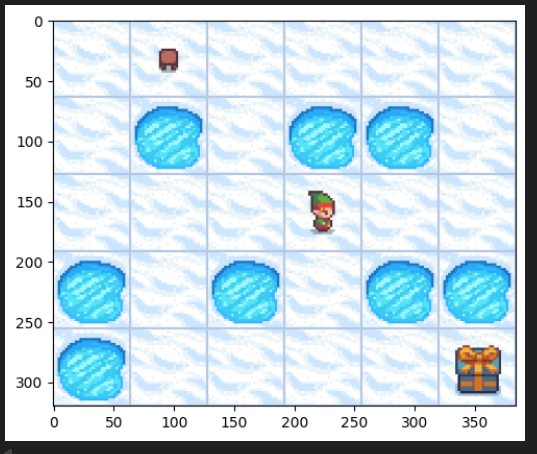

### Let's try the agent in practice

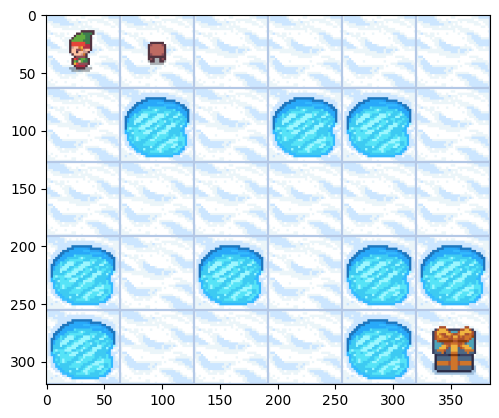

In [10]:
# let's use now the Q-table (agent) we have for this environment
# => play the game based on the Q-table but only using exploitation

# before attempting to visualize the environment, a reset() is required
env.reset()
clear_output(wait=True)
plt.imshow(env.render())
plt.show()

# run the game only for 5 steps
# don't use infinite loop because we wouldn't have a exit condition
# for-loop => allow the agent to play this 5 times in a row (5 episodes)
for episode in range(5):
    state, info = env.reset()
    done = False
    total_rewards = 0

    # play the episode until max amount of steps or until game over (win/lose)
    for step in range(max_steps):

        # get optimal action between 0-3 (left, down, right, up)
        # however you use this Q-table in this phase, is your agent's POLICY
        action = np.argmax(Q_table[state, :])

        # get the observation, reward etc. from the environment => MOVE THE ELF
        observation, reward, done, truncated, info = env.step(action)

        # update total rewards
        total_rewards = total_rewards + reward

        # clear the output
        clear_output(wait=True)

        # show the current frame of the game by using Matplotlib
        plt.imshow(env.render())
        plt.show()

        # if we either fall into a hole or find the GIFT
        if done:
            print(f"Episode {episode + 1} done with total_rewards: {total_rewards}")
            time.sleep(2)
            break
            

        state = observation

        # between the steps, add a slowdown
        # so we can actually see what's happening
        time.sleep(0.3)


# close the environment if q was pressed
env.close()

### WELL DONE ESTEBAN (ELF)!